In [1]:
import geopandas as gpd
from shapely import geometry
from shapely import wkt
from shapely.ops import unary_union
%matplotlib inline

In [2]:
gdf = gpd.read_file(r"D:\jupyter notebooks\3789.30 MHWp5 Watervrije Lijnen\hoogwatervrijelijnen.shp")
tree = gdf.sindex

In [3]:
# set buffer arround point
pt = geometry.Point((87169.016, 434250.5))
circle_buffer = pt.buffer(10000)

# find tiles that intersect the buffer boundary
# each tile is a (multi)linestring of hoogwatervrije lines and areas
bbox_matches = list(tree.intersection(circle_buffer.bounds))
gdf_matches = gdf.iloc[bbox_matches]

In [4]:
# load the fetch lines
multi_ls = 'MULTILINESTRING ((87169.016 434250.5, 105646.6066502257 441904.1686473018), (87169.016 434250.5, 104807.4412869671 443678.4347365199), (87169.016 434250.5, 103798.4082460509 445361.904660392), (87169.016 434250.5, 102629.2250672547 446938.3656832729), (87169.016 434250.5, 101311.151623731 448392.635623731), (87169.016 434250.5, 99856.88168327292 449710.7090672547), (87169.016 434250.5, 98280.42066039205 450879.8922460509), (87169.016 434250.5, 96596.95073651997 451888.9252869671), (87169.016 434250.5, 94822.68464730179 452728.0906502258), (87169.016 434250.5, 92974.70954508925 453389.3067146442), (87169.016 434250.5, 91070.82244032258 453866.2056080646), (87169.016 434250.5, 89129.35880659122 454154.194533444), (87169.016 434250.5, 87169.016 454250.5), (87169.016 434250.5, 85208.6731934088 454154.194533444), (87169.016 434250.5, 83267.20955967743 453866.2056080646), (87169.016 434250.5, 81363.32245491075 453389.3067146442), (87169.016 434250.5, 79515.3473526982 452728.0906502258))'
multi_lines = wkt.loads(multi_ls)

In [5]:
# find intersections between fetch lines and surrounding hoogwatervrije lines and areas
intersect_pts = []
for mls in gdf_matches.geometry:
    its = multi_lines.intersection(mls)
    if its:
        intersect_pts.append(its)

# merge all intersected points to list
intsect_pts_union = unary_union(intersect_pts)        

In [6]:
# find distance of the intesected points on fetch lines
points_on_line = []
for idx, line in enumerate(multi_lines):
    for point in intsect_pts_union:
        if line.distance(point) < 1e-8:
            distance = line.project(point)
            points_on_line.append({
                'geometry':geometry.LineString([pt,point]), 
                'dist':distance, 
                'zl_idx':idx
            })

In [7]:
# select fetch lines with smallest distance
gdf_zl = gpd.GeoDataFrame().from_dict(points_on_line)
gdf_dist_zl = gdf_zl.loc[gdf_zl.groupby('zl_idx')["dist"].idxmin()]

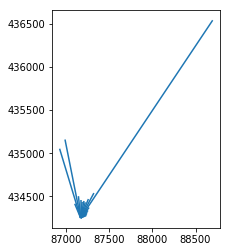

In [9]:
gdf_dist_zl.plot()

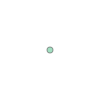

In [13]:
geometry.Point(gdf_dist_zl.geometry[0].coords[-1])